# `CLOUD.jl` - 2D linear advection

In [40]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../../ResearchDocs/ICCFD2022/"
results_path = "../results/advection_dgsem_2D/";

Define the physical problem

In [41]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);

Set up a DGSEM scheme of degree `p` with `M` elements

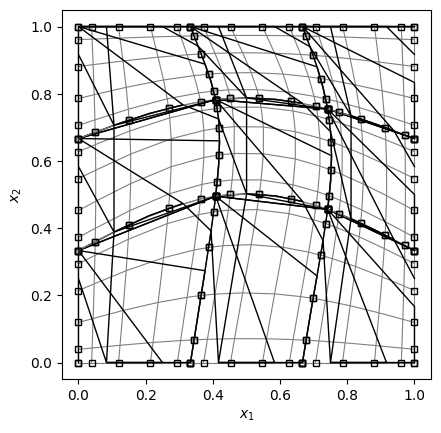

sorting by x2, perm: [5, 1, 2, 3, 4, 6] of [-0.5, 0.0, 0.5, 1.0, -1.0, 1.0]
nodes: 
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0][-1.0, -0.5, 0.0, 0.5, 1.0, 1.0]
sorting by x2, perm: [1, 6, 2, 3, 4, 5] of [-1.0, -0.5, 0.0, 0.5, 1.0, -1.0]
nodes: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0][-1.0, -1.0, -0.5, 0.0, 0.5, 1.0]
sorting by x2, perm: [1, 3, 4, 5, 2, 6] of [-1.0, 1.0, -1.0, -1.0, -1.0, 1.0]
nodes: 
 [1.0, -0.5, 0.0, 0.5, -1.0, 1.0][-1.0, -1.0, -1.0, -1.0, 1.0, 1.0]
sorting by x1, perm: [1, 3, 4, 5, 6, 2] of [-1.0, 1.0, -1.0, -0.5, 0.0, 0.5]
nodes: 
 [-1.0, -1.0, -0.5, 0.0, 0.5, 1.0][0.5, 1.0, 1.0, 1.0, 1.0, 0.5]


In [51]:
M = 3  # number of elements
p = 5  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGSEM(p), Quad(), N_plot=ceil(Int,50/M), 
    volume_quadrature_rule=LGLQuadrature(),
    facet_quadrature_rule=LGLQuadrature(),
    mapping_degree=p)
mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), collapsed=true), 
    reference_approximation.reference_element, 0.1)
spatial_discretization = SpatialDiscretization(mesh, reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data,
     WeakConservationForm(), (0.0, T), Lazy(),
     results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", 
    plot_volume_nodes=false, grid_lines=true)

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [43]:
reset_timer!()
n_s = 50
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            24.6s / 99.4%           32.9GiB / 100%     

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   37.4k    24.4s   100%   653μs   32.9GiB  100%    922KiB
   eval residual        1.35M    12.5s  51.0%  9.25μs   15.2GiB  46.3%  11.9KiB
     volume terms       1.35M    8.29s  33.9%  6.16μs   13.5GiB  41.1%  10.5KiB
     facet terms        1.35M    412ms  1.69%   306ns    349MiB  1.04%     272B
     mass matrix solve  1.35M    279ms  1.14%   207ns    472MiB  1.40%     368B
   gather external ...  1.35M    2.27s  9.31%  1.69μs   9.85GiB  30.0%  7.67KiB
   eval numerical flux  1.35M    1.60s 

Visualize the solution

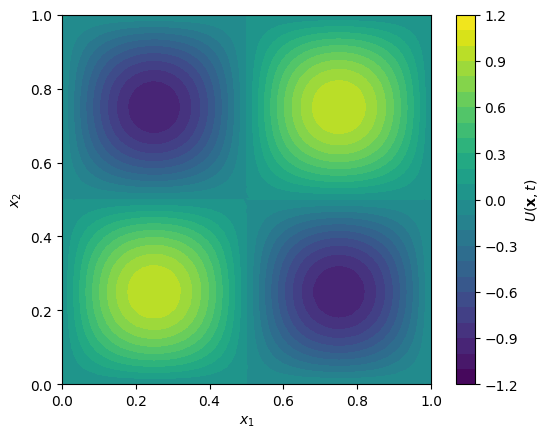

In [44]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

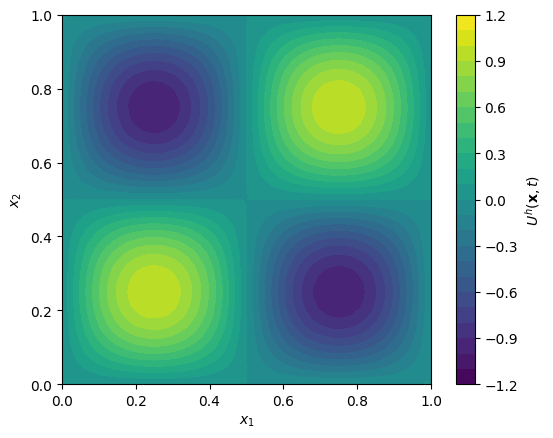

In [45]:
visualize(last(sol.u),plotter, "approx.pdf", u_range=[-1.0,1.0], contours=25, 
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [46]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.00022590910271272886]
Conservation (initial/final/diff):
[4.15089282390646e-11][4.150933416435798e-11][4.0592529337857286e-16]
Energy (initial/final/diff):
[0.24999999266443781][0.2499999926644324][-5.412337245047638e-15]
